In [1]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
# Sunspots.csv
!gdown --id 1bLnqPgwoSh6rHz_DKDdDeQyAyl8_nqT5

Downloading...
From: https://drive.google.com/uc?id=1bLnqPgwoSh6rHz_DKDdDeQyAyl8_nqT5
To: /content/Sunspots.csv
100% 70.8k/70.8k [00:00<00:00, 25.9MB/s]


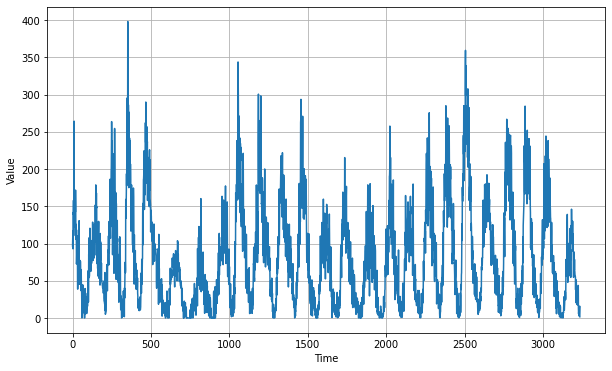

In [4]:
import csv
time_step = []
sunspots = []

with open('./Sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

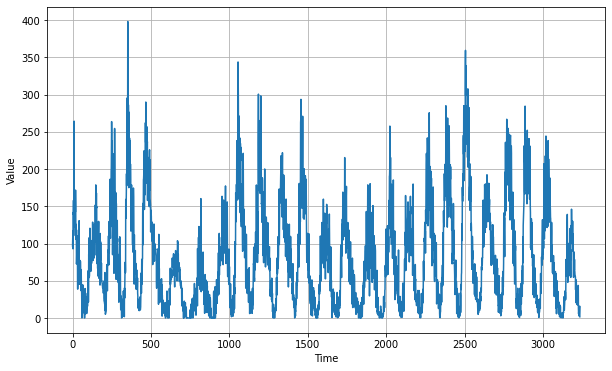

In [5]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [6]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 50
batch_size = 50
shuffle_buffer_size = 1000


In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [8]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(50).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 50
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(128, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(40, activation="relu"),
  tf.keras.layers.Dense(20, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 9s 422ms/step - loss: 43.6235 - mae: 44.1196
Epoch 2/100
12/12 [==============================] - 6s 434ms/step - loss: 41.0203 - mae: 41.5164
Epoch 3/100
12/12 [==============================] - 5s 421ms/step - loss: 39.0719 - mae: 39.5680
Epoch 4/100
12/12 [==============================] - 6s 440ms/step - loss: 38.0393 - mae: 38.5353
Epoch 5/100
12/12 [==============================] - 5s 429ms/step - loss: 37.3553 - mae: 37.8513
Epoch 6/100
12/12 [==============================] - 5s 423ms/step - loss: 36.8061 - mae: 37.3021
Epoch 7/100
12/12 [==============================] - 6s 429ms/step - loss: 36.2921 - mae: 36.7880
Epoch 8/100
12/12 [==============================] - 5s 427ms/step - loss: 35.8044 - mae: 36.3001
Epoch 9/100
12/12 [==============================] - 6s 450ms/step - loss: 35.3237 - mae: 35.8194
Epoch 10/100
12/

(1e-08, 0.0001, 0.0, 60.0)

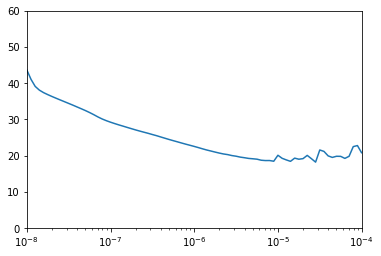

In [10]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(120, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(40, activation="relu"),
  tf.keras.layers.Dense(15, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=100)

Epoch 1/100
30/30 [==============================] - 11s 229ms/step - loss: 41.4014 - mae: 41.8979
Epoch 2/100
30/30 [==============================] - 7s 235ms/step - loss: 22.7729 - mae: 23.2669
Epoch 3/100
30/30 [==============================] - 7s 228ms/step - loss: 20.6401 - mae: 21.1333
Epoch 4/100
30/30 [==============================] - 7s 237ms/step - loss: 19.1531 - mae: 19.6457
Epoch 5/100
30/30 [==============================] - 7s 232ms/step - loss: 18.5741 - mae: 19.0664
Epoch 6/100
30/30 [==============================] - 7s 239ms/step - loss: 18.3968 - mae: 18.8892
Epoch 7/100
30/30 [==============================] - 7s 234ms/step - loss: 17.9704 - mae: 18.4624
Epoch 8/100
30/30 [==============================] - 7s 232ms/step - loss: 17.8079 - mae: 18.3003
Epoch 9/100
30/30 [==============================] - 8s 242ms/step - loss: 17.8002 - mae: 18.2924
Epoch 10/100
30/30 [==============================] - 7s 230ms/step - loss: 17.5925 - mae: 18.0847
Epoch 11/100
30/30

In [14]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

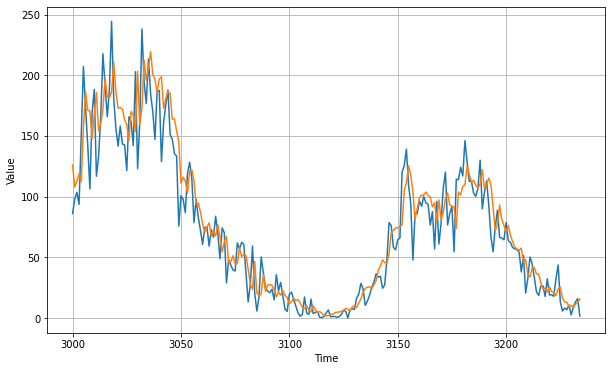

In [15]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [16]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

14.851704

<Figure size 432x288 with 0 Axes>

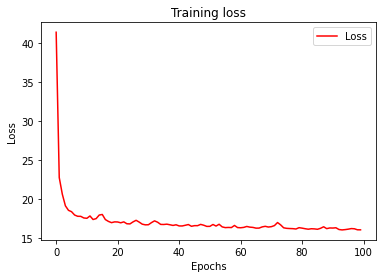

<Figure size 432x288 with 0 Axes>

In [20]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [21]:
print(rnn_forecast)

[125.972786  107.962524  112.72138   119.10765   112.14342   155.98627
 186.3926    171.01988   170.54677   147.63057   167.61461   185.76936
 154.24649   159.71204   171.83595   197.49721   182.05676   181.38673
 186.26573   210.63559   186.2787    172.85      173.40855   171.7226
 163.28978   159.27129   146.10138   170.24574   167.04736   153.48921
 203.1955    159.21078   173.09706   212.42549   195.92767   206.08826
 219.42966   200.91953   196.39096   185.84734   196.88478   198.73665
 172.67622   180.51207   186.93152   184.91579   163.83269   164.00012
 154.16644   145.18687   110.918655  116.058754  113.014725  102.738144
 121.242905  122.11397   113.0063     93.67507    94.74484    87.33536
  77.32845    70.70048    74.893234   78.32657    67.66734    71.72803
  67.5563     76.919876   66.968155   54.431385   62.73047    67.13799
  45.753143   46.264355   51.2805     44.735752   44.624935   57.797897
  50.562286   52.644115   51.281715   40.203907   27.875889   23.71478
  46.